# Topic Modelling of Conflict on the African Continent from '97-'22

'[‘Little to lose’: Poverty and despair fuel South Africa’s unrest'](https://www.aljazeera.com/news/2021/7/14/little-to-lose-poverty-and-despair-fuel-south-africas-unrest) reads an Aljazeera headline published on 14 Jul 2021. Are these words just another attention grabbing headline to sell papers or is there some truth to it? Does economic inequality fuel unrest? To answer this question would require a massive amount of data and computing power. What this notebbok attempts to do is scale down this question  to: Is there a pattern in the themes or topics of unrest across the African continent and do they at least have a linear relationship to a country's economic status? 

# Datasets
1. [ACLED](https://acleddata.com/about-acled/)
> The Armed Conflict Location & Event Data Project (ACLED) collects data on conflicts and unrest around the world. This project used ACLED data for Africa from 1997 t0 2022.
2. [WorldBank GDP annual growth](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=ZG)
>  GDP gives information about the size of the economy and how an economy is performing and  is often used as an indicator of the general health of the economy. GDP annual growth rates for Sub Saharan Africa were used.


In [1]:
!pip install -r '../input/acledvtwist/requirements.txt'
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 4.1 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore' )

In [14]:
df=pd.read_excel("../input/africaxls/Africa_1997-2022_Apr08.xlsx")
df.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
0,12,ALG1,1,1997-01-01,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Douaouda,36.672,2.789,1,Algeria Watch,Other,5 January: Beheading of 5 citizens in Douaouda...,5,1582579226
1,12,ALG2,2,1997-01-02,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Hassasna,36.133,0.883,1,Algeria Watch,Other,Two citizens were beheaded in Hassasna.,2,1582579226
2,12,ALG3,3,1997-01-03,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Hassi El Abed,34.966,-0.290,1,Algeria Watch,Other,Two citizens were killed in a raid on the vill...,2,1582579226
3,12,ALG4,4,1997-01-04,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Blida,36.469,2.829,1,Algeria Watch,Other,4 January: 16 citizens were murdered in the vi...,16,1582579226
4,12,ALG5,5,1997-01-05,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Douaouda,36.672,2.789,1,Algeria Watch,Other,5 January: Killing of 18 citizens in the Olivi...,18,1582579226


In [4]:
news = df.EVENT_TYPE.unique()
news

array(['Violence against civilians', 'Battles',
       'Explosions/Remote violence', 'Protests', 'Strategic developments',
       'Riots'], dtype=object)

In [5]:
keywords = df.SUB_EVENT_TYPE.unique()
keywords

array(['Attack', 'Armed clash', 'Remote explosive/landmine/IED',
       'Shelling/artillery/missile attack', 'Peaceful protest',
       'Change to group/activity', 'Looting/property destruction',
       'Government regains territory', 'Disrupted weapons use',
       'Protest with intervention', 'Violent demonstration',
       'Mob violence', 'Air/drone strike', 'Other', 'Arrests',
       'Excessive force against protesters',
       'Abduction/forced disappearance', 'Suicide bomb', 'Grenade',
       'Non-violent transfer of territory',
       'Headquarters or base established', 'Agreement',
       'Non-state actor overtakes territory', 'Sexual violence',
       'Chemical weapon'], dtype=object)

[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


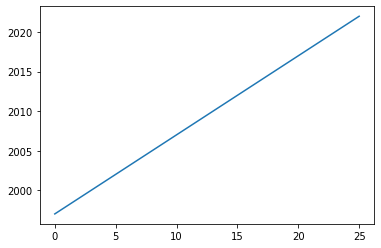

In [6]:
#Is there a gap in the reporting period?
import matplotlib.pyplot as plt
year = df.YEAR.unique()
plt.plot(year)
print(year)

In [7]:
countries=df.COUNTRY.unique()
countries

array(['Algeria', 'Angola', 'Botswana', 'Burundi', 'Cameroon',
       'Cape Verde', 'Central African Republic', 'Chad', 'Comoros',
       'Mayotte', 'Republic of Congo', 'Democratic Republic of Congo',
       'Benin', 'Equatorial Guinea', 'Ethiopia', 'Eritrea', 'Djibouti',
       'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Ivory Coast', 'Kenya',
       'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia',
       'Niger', 'Nigeria', 'Guinea-Bissau', 'Reunion', 'Rwanda',
       'Saint Helena, Ascension and Tristan da Cunha',
       'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone',
       'Somalia', 'South Africa', 'Zimbabwe', 'South Sudan', 'Sudan',
       'eSwatini', 'Togo', 'Tunisia', 'Uganda', 'Egypt', 'Tanzania',
       'Burkina Faso', 'Zambia'], dtype=object)

# NLP Pre-processing of columns of interest
> Prepare the columns with country, notes, event type and subtype for downstream NLP analysis 

In [8]:
#Tokenization and dpre-processing for nlp
import string
punct = string.punctuation
import spacy
#from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
#nlp.add_pipe("spacytextblob")
stopwords = list(STOP_WORDS)


def text_data_cleaning(sentence):
    '''
    
    Takes a text and pre-processes it for downstream nlp
    input: single document
    output: returns a tokenised document
    
    '''
    #try to remove numbers and months
   
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
        

    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [15]:
# #create a column for cleaned and tokenised categories
df= df.loc[:10000]
df['SUB_EVENT_TYPE_mod']= df.SUB_EVENT_TYPE.apply(text_data_cleaning)
df.head(1)

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,SUB_EVENT_TYPE_mod
0,12,ALG1,1,1997-01-01,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,Douaouda,36.672,2.789,1,Algeria Watch,Other,5 January: Beheading of 5 citizens in Douaouda...,5,1582579226,[attack]


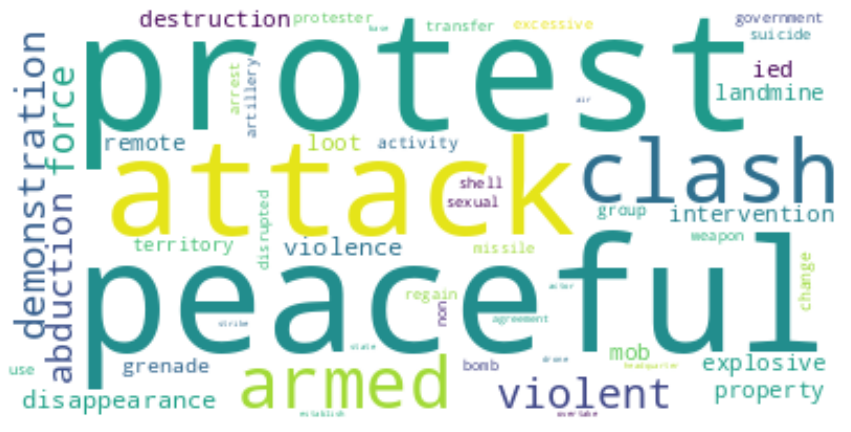

In [16]:
#df =pd.read_csv("../input/african-unrest-reduced/African_unrest.csv")

from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(df['SUB_EVENT_TYPE_mod'])).value_counts()[:]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)
df.SUB_EVENT_TYPE.head()
plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
def text_cleaning(sentence):
    '''
    
    Takes a text and pre-processes it for downstream nlp with numbers and months removed
    input: single document
    output: returns a tokenised document
    
    '''
    #try to remove numbers and months
   
    doc = nlp(sentence)
    unwanted = ['2020','2021','2018','2019','report', 'size', 'area','group','member',
                'january', 'february', 'march', 'april', 'may', 'june', 
                'july', 'august', 'september', 'october','november', 'december']

    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
        
    #num =re.search('\b([1-9]|[12][0-9]|3[01])\b')
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct and token not in unwanted and token.isnumeric() ==False:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [ ]:
#create a column for cleaned and tokenised notes

df['NOTES'] = df['NOTES'].astype(str)
df['NOTES_mod']= df.NOTES.apply(text_cleaning)
df.head(1)

In [ ]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(df['NOTES_mod'])).value_counts()[:]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)
df.NOTES_mod.head()
plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#df_new = df.filter(['EVENT_DATE','YEAR','COUNTRY','COUNTRY_mod','EVENT_TYPE_mod','SUB_EVENT_TYPE_mod','NOTES_mod','NOTES_clean', 'FATALITIES','LATITUDE','LONGITUDE'],axis=1)
#df_new.head(2)

In [ ]:
df_new = df.filter(['EVENT_DATE','YEAR','COUNTRY','NOTES', 'NOTES_mod','FATALITIES','LATITUDE','LONGITUDE'],axis=1)
df_new.head(2)

In [ ]:
df_new.to_csv('African_unrest.csv', index=False)


# Topic Modelling

In [26]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline


Loading BokehJS ...

In [19]:
#Import modified data and parse dates
datafile = '../input/african-unrestcsv/African_unrest.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)


raw_data.head()

,EVENT_DATE,YEAR,COUNTRY,NOTES,NOTES_mod,FATALITIES,LATITUDE,LONGITUDE
0,1997-01-01,1997,Algeria,5 January: Beheading of 5 citizens in Douaouda...,"['beheading', 'citizen', 'douaouda', 'tipaza']",5,36.672,2.789
1,1997-01-02,1997,Algeria,Two citizens were beheaded in Hassasna.,"['citizen', 'behead', 'hassasna']",2,36.133,0.883
2,1997-01-03,1997,Algeria,Two citizens were killed in a raid on the vill...,"['citizen', 'kill', 'raid', 'village', 'hassi'...",2,34.966,-0.290
3,1997-01-04,1997,Algeria,4 January: 16 citizens were murdered in the vi...,"['citizen', 'murder', 'village', 'benachour', ...",16,36.469,2.829
4,1997-01-05,1997,Algeria,5 January: Killing of 18 citizens in the Olivi...,"['killing', 'citizen', 'oliviers', 'district',...",18,36.672,2.789


In [20]:
#Re-index data to use DateTime object
reindexed_data = raw_data['NOTES_mod']
reindexed_data.index =raw_data['EVENT_DATE']
raw_data.head(1)

,EVENT_DATE,YEAR,COUNTRY,NOTES,NOTES_mod,FATALITIES,LATITUDE,LONGITUDE
0,1997-01-01,1997,Algeria,5 January: Beheading of 5 citizens in Douaouda...,"['beheading', 'citizen', 'douaouda', 'tipaza']",5,36.672,2.789


In [24]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

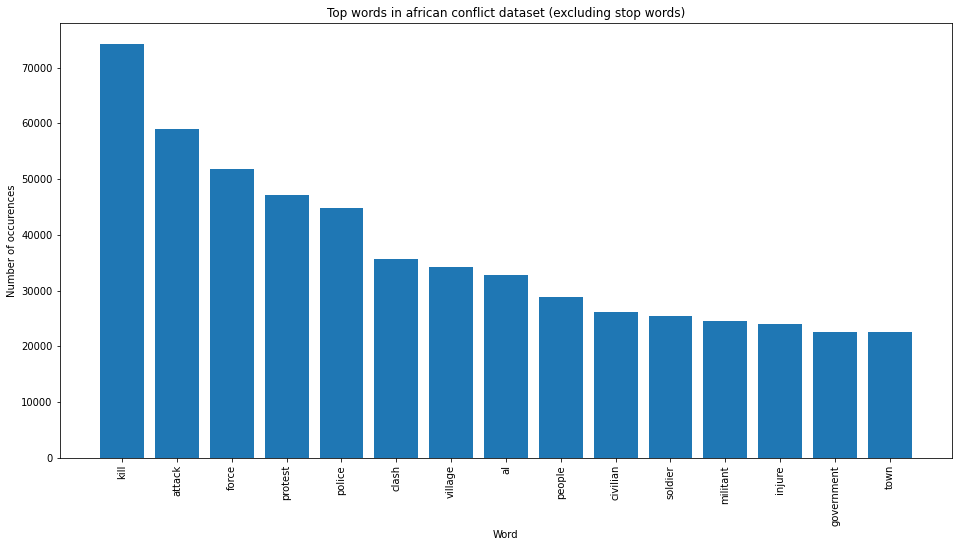

In [28]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in african conflict dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [81]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

KeyboardInterrupt: 

In [ ]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

In [ ]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Notes word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Notes Corpus');
ax.set_xlabel('Type of Word');

In [ ]:
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0, replace=True).values

print('Notes before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Notes after vectorization: \n{}'.format(small_document_term_matrix[123]))

In [ ]:
n_topics = 6

In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

In [ ]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');


In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

In [55]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [34]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

### Do these topics form distinct clusters?

> We use t-SNE clustering to determine if the topics in the data are distinct or closely related.

In [80]:
#Visualise topics clusters 
top_5_words_lda = get_top_n_words(5, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_5_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

NameError: name 'lda_keys' is not defined

# Topic Modeling on Complete dataset

> We can now model the whole dataset and see the topics acroos Africa from 97 to date

In [50]:
big_sample_size = 276490

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [57]:
yearly_data = []
for i in range(1997,2022+1):
    
    yearly_data.append(reindexed_data.loc['{}'.format(i)].values)

yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(1997,2022+1))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]


yearly_conflict = pd.DataFrame(np.array(yearly_data), index=range(1997,2022+1))

print(yearly_topic_counts)

      Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6
1997      415      409      435      709     1178       63
1998      484      493      359     1168     1941      101
1999     1241      474     2063      425      471      208
2000     1457      442      960      522      524      270
2001      417      212      528      753     1167      534
2002      796     1565      685      573      477      201
2003      644      994      424      437     1092      159
2004      490      296      752      823      713      100
2005      785      672      466      677      272       37
2006      415      581      905      234      568       36
2007     1520      746      510      437      632       52
2008     2197      467      739      893      680      107
2009      936      470      725      764      892       76
2010     1050      942     1103      489      757       55
2011     1437     3100      803     1452     1231      113
2012     2412     2802     1471     1276     1700      1

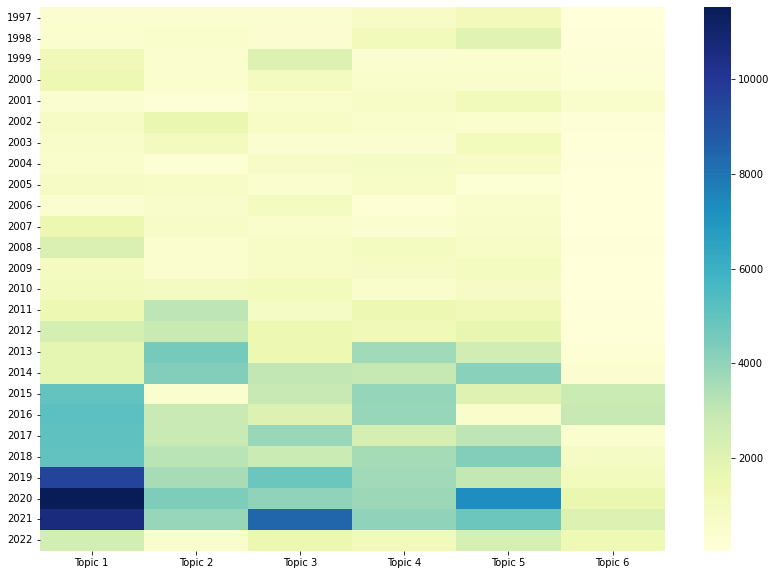

In [58]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()

## Group the data by year

> Since the goal is to assess topics for Afica as a whole, grouping by year is more informative.

In [35]:
df= pd.read_csv('../input/african-unrestcsv/African_unrest.csv')
df.head(1)

,EVENT_DATE,YEAR,COUNTRY,NOTES,NOTES_mod,FATALITIES,LATITUDE,LONGITUDE
0,1997-01-01,1997,Algeria,5 January: Beheading of 5 citizens in Douaouda...,"['beheading', 'citizen', 'douaouda', 'tipaza']",5,36.672,2.789


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4a027971-fa43-4fea-9cbd-70262a03c740' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

# Does economic status affect theme's or types of protests?

In [37]:
# Import economic data
economy_df=pd.read_csv('../input/economics/Economics.csv', engine='python')
economy_df.head(1)

,Country Name,Country Code,Indicator Name,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,GDP growth (annual %),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.446055,-1.369863,4.198232,0.3,5.700001,2.1,1.999999,NaN,NaN,NaN


In [41]:
#change from wide to ong format
df_economy = pd.melt(economy_df, id_vars='Country Name', value_vars=['1997', '1998','1999','2000',\
                                                                     '2001','2002','2003','2004','2005',\
                                                                     '2006','2007','2008','2009','2010',\
                                                                     '2011','2012','2013','2014','2015',\
                                                                     '2016','2017','2018','2019','2020'],\
                     var_name ='Year', value_name ='GDP_change'
                     
                    )

df_economy.to_csv('eco.csv')
df_economy.head(1)

#df_economy=pd.read_csv('/kaggle/working/eco.csv') for loading 

,Country Name,Year,GDP_change
0,Aruba,1997,7.046874


In [38]:
data = pd.read_csv("../input/african-unrestcsv/African_unrest.csv")
#data=pd.read_excel("../input/africaxls/Africa_1997-2022_Apr08.xlsx")
data.head(1)

,EVENT_DATE,YEAR,COUNTRY,NOTES,NOTES_mod,FATALITIES,LATITUDE,LONGITUDE
0,1997-01-01,1997,Algeria,5 January: Beheading of 5 citizens in Douaouda...,"['beheading', 'citizen', 'douaouda', 'tipaza']",5,36.672,2.789


In [39]:
#restructure data by year
yearly_summary = (data.groupby(["YEAR", "COUNTRY"])['NOTES_mod']
           .apply(', '.join)
           .reset_index())
yearly_summary.columns.name = None
yearly_summary.head()

,YEAR,COUNTRY,NOTES_mod
0,1997,Algeria,"['beheading', 'citizen', 'douaouda', 'tipaza']..."
1,1997,Angola,"['total', 'number', 'chief', 'past', 'month', ..."
2,1997,Benin,"['teacher', 'protest', 'working', 'condition']..."
3,1997,Botswana,"['zambians', 'resident', 'botswana', 'yesterda..."
4,1997,Burkina Faso,"['police', 'fire', 'teargas', 'protester', 'de..."


In [42]:
#select only-SubSaharan countries form economy
import re

pattern ='|'.join(data.COUNTRY.unique())

df_economy['Countries']= df_economy['Country Name'].str.contains(pat=pattern,flags=re.IGNORECASE, regex=True)

economy_summary = df_economy[(df_economy.Countries == True)]
print(economy_summary.shape)
economy_summary.head()

(1224, 4)


,Country Name,Year,GDP_change,Countries
4,Angola,1997,7.274277,True
16,Burundi,1997,-1.590000,True
18,Benin,1997,5.734688,True
19,Burkina Faso,1997,6.316835,True
33,Botswana,1997,8.325891,True


In [43]:
#Smmarise data set using median of GDp
economy= (economy_summary.groupby(['Year'])['GDP_change'].median())
economy= economy.reset_index()
economy.head()

,Year,GDP_change
0,1997,4.527314
1,1998,3.917075
2,1999,3.200002
3,2000,3.585698
4,2001,3.796272


In [44]:
#yearly_summary['GDP_change']= yearly_summary['YEAR']
yearly_summary['YEAR']=yearly_summary['YEAR'].astype(str)
yearly_summary.head()

,YEAR,COUNTRY,NOTES_mod
0,1997,Algeria,"['beheading', 'citizen', 'douaouda', 'tipaza']..."
1,1997,Angola,"['total', 'number', 'chief', 'past', 'month', ..."
2,1997,Benin,"['teacher', 'protest', 'working', 'condition']..."
3,1997,Botswana,"['zambians', 'resident', 'botswana', 'yesterda..."
4,1997,Burkina Faso,"['police', 'fire', 'teargas', 'protester', 'de..."


In [45]:
#join the two data frames on year
df_yearly=economy.merge(yearly_summary, left_on= 'Year', right_on='YEAR', how='left', copy=True)
df_yearly['GDP_median']=df_yearly['GDP_change']
df_yearly.head()
#df_yearly= df_yearly.dropna(axis=1)

,Year,GDP_change,YEAR,COUNTRY,NOTES_mod,GDP_median
0,1997,4.527314,1997,Algeria,"['beheading', 'citizen', 'douaouda', 'tipaza']...",4.527314
1,1997,4.527314,1997,Angola,"['total', 'number', 'chief', 'past', 'month', ...",4.527314
2,1997,4.527314,1997,Benin,"['teacher', 'protest', 'working', 'condition']...",4.527314
3,1997,4.527314,1997,Botswana,"['zambians', 'resident', 'botswana', 'yesterda...",4.527314
4,1997,4.527314,1997,Burkina Faso,"['police', 'fire', 'teargas', 'protester', 'de...",4.527314


In [46]:
df_yearly = df_yearly.set_index('YEAR')
df_yearly.head()

,Year,GDP_change,COUNTRY,NOTES_mod,GDP_median
YEAR,,,,,
1997,1997,4.527314,Algeria,"['beheading', 'citizen', 'douaouda', 'tipaza']...",4.527314
1997,1997,4.527314,Angola,"['total', 'number', 'chief', 'past', 'month', ...",4.527314
1997,1997,4.527314,Benin,"['teacher', 'protest', 'working', 'condition']...",4.527314
1997,1997,4.527314,Botswana,"['zambians', 'resident', 'botswana', 'yesterda...",4.527314
1997,1997,4.527314,Burkina Faso,"['police', 'fire', 'teargas', 'protester', 'de...",4.527314


In [47]:
reindexed = df_yearly['NOTES_mod']
reindexed.index = df_yearly['GDP_change']
reindexed.head(1)

GDP_change
4.527314    ['beheading', 'citizen', 'douaouda', 'tipaza']...
Name: NOTES_mod, dtype: object

### Is the heatmap different when median GDP is used as an index?


In [82]:

GDP_data = []
for i in df_yearly['GDP_change']:
        GDP_data.append(reindexed.loc[i].values)
for year in GDP_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    GDP_data_topic_matrices.append(topic_matrix)
    
    #lda_keys = get_keys(topic_matrix)
    #lda_categories, lda_counts = keys_to_counts(lda_keys)

GDP_data_keys = []
for topic_matrix in GDP_data_topic_matrices:
    GDP_data_keys.append(get_keys(topic_matrix))
    
GDP_data_counts = []
for keys in GDP_data_keys:
    categories, counts = keys_to_counts(keys)
    GDP_data_counts.append(counts)

GDP_data_topic_counts = pd.DataFrame(np.array(GDP_data_counts))
GDP_data_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]


GDP_data_conflict = pd.DataFrame(np.array(GDP_data))

print(GDP_data_topic_counts)

fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(GDP_data_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 6 elements

In [ ]:

yearly_data = []
for i in df_yearly['GDP_change']:
        yearly_data.append(reindexed.loc[i].values)
yearly_topic_matrices = []
for year in yearly_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    yearly_topic_matrices.append(topic_matrix)

yearly_keys = []
for topic_matrix in yearly_topic_matrices:
    yearly_keys.append(get_keys(topic_matrix))
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(-5,10+1, 6))
yearly_topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n_topics)]


yearly_conflict = pd.DataFrame(np.array(yearly_data), index=range(-5,10+1, 6))

print(yearly_topic_counts)

# Conclusion, Challenged and Lessons Learned

* Topic model is useful gaining insight into unstructured themes e.g conflict
* Insights will be mor meaningful is broken down into countris but would also reduce the dataset
* While having incredible amounts of data, how useful a public datset is depends on an individual's purpose
* 